# Task 1

A fixed point of some function $f$ is a number $x$ such that $f(x) = x$. One method to find such points is functional iteration, where successive guesses are generated by repeated application of the function. The following routine implements this method, iterating until the desired accuracy is achieved or a maximum iteration count is reached.

In [1]:
function fixed_point(f, x0, tol=1e-6, max=100)
    y = f(x0)
    if abs(x0 - y) < tol || max ≤ 0
        x0
    else
        fixed_point(f, y, tol, max - 1)
    end
end

fixed_point (generic function with 3 methods)

The zero of a function $f$ can be found by computing the fixed point of another function, $g(x) = x \pm f(x)$:

In [2]:
function functional_iter(f, x0, tol=1e-6, max=100)
    fixed_point(x -> x - f(x), x0, tol, max),
    fixed_point(x -> x + f(x), x0, tol, max)
end

functional_iter (generic function with 3 methods)

Now we can test this method of root finding. Note that sometimes, only one of the $g(x)$ functions converges.

In [3]:
f(x) = x * exp(-x)
functional_iter(f, 1)

(9.439212148590554e-10, 6.237041784975049)

# Task 2

This version of the fixed point method tabulates some data while running, including: iteration count, guess, and error.

In [4]:
function fixed_point_tab(f, x0, tol=1e-6, max=100, iter=1, tab=Matrix(undef, 0, 3))
    y = f(x0)
    err = abs(x0 - y)
    if err < tol || max ≤ 0
        x0, tab
    else
        fixed_point_tab(f, y, tol, max - 1, iter + 1, [tab; iter x0 err])
    end
end

function functional_iter_tab(f, x0, tol=1e-6, max=100)
    fixed_point_tab(x -> x - f(x), x0, tol, max),
    fixed_point_tab(x -> x + f(x), x0, tol, max)
end

functional_iter_tab (generic function with 3 methods)

Below, the successive guesses tabulated by the algorithm are plotted. Note that the execution using $g(x) = x - f(x)$ converges to $x = 0$:

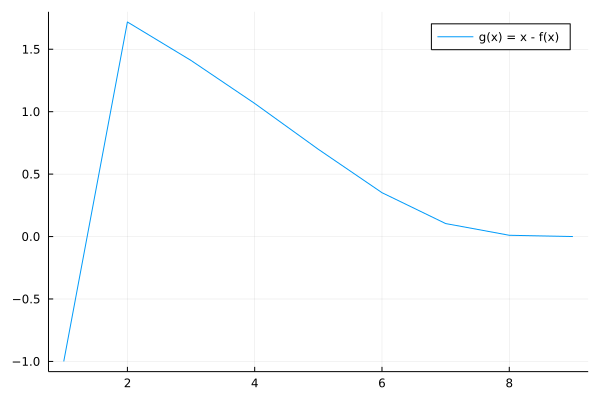

In [5]:
(_, tab_minus), (_, tab_plus) = functional_iter_tab(x -> x * exp(-x), -1)

using Plots
guess_minus = tab_minus[:, 2]
plot(guess_minus, label="g(x) = x - f(x)")

However, $g(x) = x + f(x)$ quickly diverges:

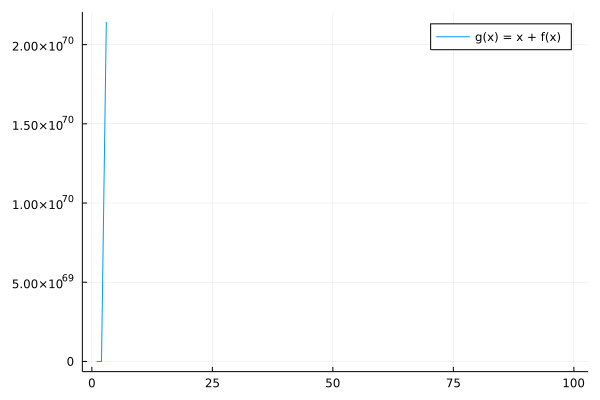

In [6]:
guess_plus = tab_plus[:, 3]
plot(guess_plus, label="g(x) = x + f(x)")

# Task 3

The following function has many zeros on the interval of interest, and a singularity at $x = 0$.

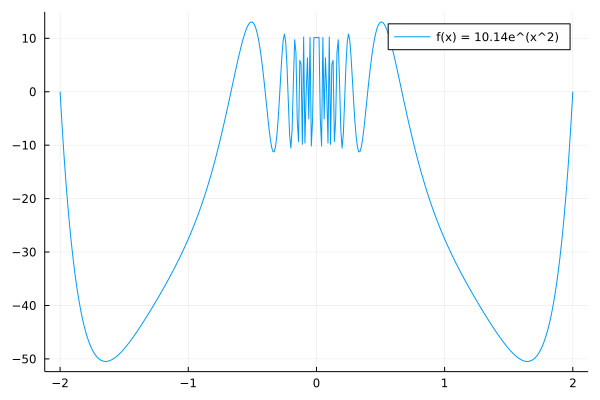

In [7]:
f(x) = 10.14 * exp(x^2) * cos(pi / x)
domain = [x for x in -2:.01:2 if x != 0] # Avoid singularity at 0
plot(domain, f, label="f(x) = 10.14e^(x^2)")

Functional iteration isn't very successful at finding zeros for this function. Given 100 different initial guesses in $(0, 1)$, most cause the algorithm to diverge. The two guesses that don't diverge happen to be zeros already.

In [8]:
zeros = functional_iter.(f, 0.01:.01:1)
[a for (a, _) in zeros if !isinf(a)]

2-element Vector{Float64}:
 0.08
 0.4

Initial guesses that deviate from these values even slightly will not converge:

In [9]:
functional_iter(f, 0.09),
functional_iter(f, 0.39)

((-Inf, Inf), (-Inf, Inf))

# Task 4

The bisection method for zero-finding takes advantage of the Intermediate Value Theorem: for an interval $(a, b)$ where $f(a)$ and $f(b)$ have different sign, there is a zero in $(a, b)$. We repeatedly find the midpoint of this interval, and search the half-interval containing a zero. In this way, our error starts as $e = b - a$ and is halved at every step. Thus for $k$ iterations of the algorithm we have $e = \frac{b - a}{2^k}$. If we wish to iterate until $e \le \epsilon$ for some desired accuracy $\epsilon$, we can simply solve for $k$. This yields $k \ge log_2(\frac{b-a}{\epsilon})$. This relationship can be used to compute $k$ such that our error is within bounds.

In [10]:
function bisection(f, a, b, tol=1e-6)
    k = ceil(-log2(tol/(b-a)))
    
    for i in 1:k
        midpoint = (a + b) / 2
        fa, fm, fb = f.([a, midpoint, b])
        
        if fa * fm < 0
            b = midpoint
        elseif fm * fb < 0
            a = midpoint
        else
            error(string("Could not locate zero in interval ", a, ", ", b))
        end
    end
    
    # Ensure we achieved desired accuracy
    @assert b - a < tol
    
    (a + b) / 2
end

bisection (generic function with 2 methods)

For example, here the bisection method is used to correctly estimate the zero of $x^2 - 3$, to within $\epsilon = 10^{-12}$.

In [11]:
tol = 1e-12
x = bisection(x -> x^2 - 3, 0, 10, tol)
x - sqrt(3) < tol

true

The bisection algorithm can be modified to tabulate results as well.

In [12]:
function bisection_tab(f, a, b, tol=1e-6)
    tab = Matrix(undef, 0, 3)
    k = ceil(-log2(tol/(b-a)))
    
    for i in 1:k
        midpoint = (a + b) / 2
        fa, fm, fb = f.([a, midpoint, b])
        
        tab = [tab; i midpoint (b - a)]
        
        if fa * fm < 0
            b = midpoint
        elseif fm * fb < 0
            a = midpoint
        else
            error(string("Could not locate zero in interval ", a, ", ", b))
        end
    end
    
    # Ensure we achieved desired accuracy
    @assert b - a < tol
    
    (a + b) / 2, tab
end

bisection_tab (generic function with 2 methods)

These results illustrate how the bisection method steadily cuts the error by $\frac{1}{2}$ every iteration:

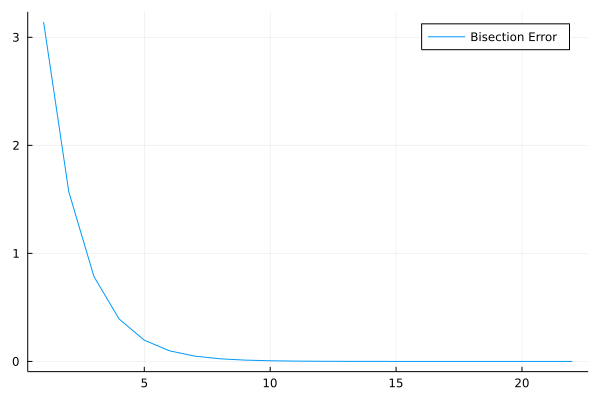

In [14]:
_, tab = bisection_tab(cos, 0, pi)
err = tab[:, 3]
plot(err, label="Bisection Error")

# Task 5

My repository for this class is located at: https://github.com/CarsonFox/math4610